In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
from astropy.io import fits
from tqdm import tqdm
import camb

import glass.shells
import glass.lensing

from mass_mapping import kaiser_squire

In [3]:
nside = 1024
lmax = 2*nside
pw = hp.pixwin(nside, lmax=lmax)
print(pw)

[1.         0.99999995 0.99999984 ... 0.82759132 0.82743558 0.8272798 ]


In [4]:
sim_cls = []
camb_cls = []

for i in tqdm(range(791)):
    path_sim = f"/lustre/fswork/projects/rech/prk/commun/GowerStreetSims/full_sky_processing/forward_model_sim{i+1:05d}_nside1024_rot00_noisereal0.npy"
    if os.path.exists(path_sim) and i+1 not in [150, 247, 281, 315, 659, 785, 786, 787]:
        output = np.load(path_sim, allow_pickle=True).item()
    else:
        continue
    #Checking the power spectrum of the convergence and shear fields
    #Load parameters for the cosmology
    h = output['cosmo_params']["h"]
    Om = output['cosmo_params']["Omega_m"]
    Ob = output['cosmo_params']["Omega_b"]
    Oc = Om - Ob
    ns = output['cosmo_params']["n_s"]
    m_nu = output['cosmo_params']["m_nu"]
    w = output['cosmo_params']["w"]
    As = output['cosmo_params']["A_s"]
    
    nside = 1024
    lmax = 2*nside
    
    pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
    Onu = pars.omeganu
    Oc = Om - Ob - Onu
    pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
    
    #get the angular power spectra of the lensing map
    sim_cls.append(output['bin_1']['cl_FS_gamma'][0])
    
    redshift_distr = np.loadtxt(output['config']['redshift_distribution']['path_dndz'])
    z, dndz = redshift_distr[:, 0], redshift_distr[:, 1]
    
    #getthe expected cl's from CAMB
    pars.min_l = 1
    pars.set_for_lmax(lmax)
    pars.SourceWindows = [
        camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
    ]
    theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)
    camb_cls.append(theory_cls['W1xW1']*pw**2)

100%|██████████| 791/791 [1:21:49<00:00,  6.21s/it]


In [5]:
sim_cls = np.array(sim_cls)
camb_cls = np.array(camb_cls)

In [6]:
ratio_cls = sim_cls/camb_cls

/tmp/ipykernel_2440820/2732921704.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio_cls = sim_cls/camb_cls


In [7]:
mean_ratio_cls = np.mean(ratio_cls, axis=0)
std_ratio_cls = np.std(ratio_cls, axis=0)

/linkhome/rech/genaim01/uid35yw/.conda/envs/glass/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


/tmp/ipykernel_2440820/1188543074.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Power spectra on the full-sky maps')

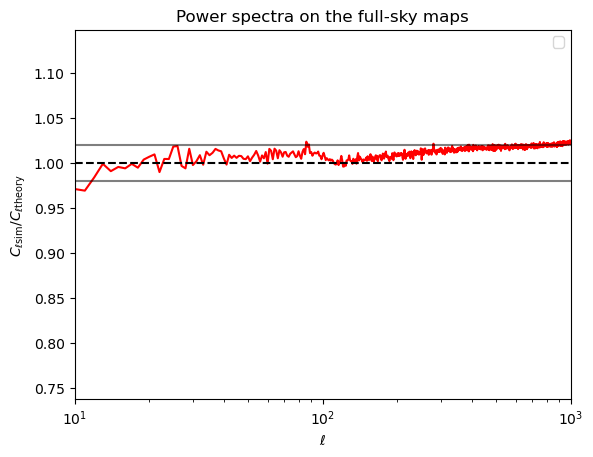

In [9]:
plt.figure()

lmax = 2*nside
l = np.arange(lmax+1)
#for i in range(510, 520):
#    plt.plot(l, ratio_cls[i], c='g', alpha=0.5)
plt.plot(l, mean_ratio_cls, c='r', ls='-')

plt.axhline(1, linestyle='--', c='k')
plt.axhline(1.02, c='k', alpha=0.5)
plt.axhline(0.98, c='k', alpha=0.5)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell \rm{sim}}/C_{\ell \rm{theory}}$')
plt.legend()

plt.xscale('log')
plt.xlim(10, 1000)

plt.title('Power spectra on the full-sky maps')

In [44]:
camb_cls[0]

array([0.00000000e+00, 2.33283177e-08, 2.48850024e-08, ...,
       1.11158000e-10, 1.10998224e-10, 1.10838766e-10])

In [23]:
std_ratio_cls

array([       nan, 0.64430107, 0.52194416, ..., 1.19338   , 1.17868601,
       1.20762018])

In [45]:
pw

array([1.        , 0.99999995, 0.99999984, ..., 0.95442017, 0.95433269,
       0.95424514], dtype='>f8')

In [26]:
i = 2
path_sim = f"/lustre/fswork/projects/rech/prk/commun/GowerStreetSims/UNIONS_processing/forward_model_sim{i+1:05d}_nside0512_rot00_noisereal0.npy"
if os.path.exists(path_sim):
    output = np.load(path_sim, allow_pickle=True).item()

In [27]:
output

{'cosmo_params': {'h': array([0.72268436]),
  'Omega_m': array([0.33047284]),
  'Omega_b': array([0.04294964]),
  'sigma_8': array([0.60764534]),
  'n_s': array([0.95235846]),
  'w': array([-1.22975854]),
  'm_nu': array([0.06]),
  'A_s': array([1.0000006e-09])},
 'config': {'intrinsic_alignment': {'add_ia': 'T',
   'prior_A_ia': [0.5, 0.8],
   'prior_A_ia_type': 'gaussian'},
  'n_noise_real': 2,
  'preprocessing': {'nside': 512},
  'psf_systematic': {'add_systematic': 'T',
   'dec_col': 'DEC',
   'e1_psf_col': 'E1_PSF_HSM',
   'e1_star_col': 'E1_STAR_HSM',
   'e2_psf_col': 'E2_PSF_HSM',
   'e2_star_col': 'E2_STAR_HSM',
   'hdu': 1,
   'path_prior_params': '/lustre/fswork/projects/rech/prk/uid35yw/UNIONS_forward_model/data_utils/prior_psf_sys_SP_v1.4.5_leak_corr.npy',
   'path_psf': '/lustre/fsn1/projects/rech/prk/uid35yw/unions_shapepipe_psf_2024_v1.4.a.fits',
   'ra_col': 'RA',
   'size_psf_col': 'SIGMA_PSF_HSM',
   'size_star_col': 'SIGMA_STAR_HSM',
   'square_size': True},
  'ray_t

In [2]:
sim_cls = []
camb_cls = []

for i in tqdm(range(500, 791)):
    path_sim = f"/lustre/fswork/projects/rech/prk/commun/GowerStreetSims/full_sky_processing/forward_model_sim{i+1:05d}_nside1024_rot00_noisereal0.npy"
    if os.path.exists(path_sim):
        output = np.load(path_sim, allow_pickle=True).item()
    else:
        continue
    #Checking the power spectrum of the convergence and shear fields
    #Load parameters for the cosmology
    h = output['cosmo_params']["h"]
    Om = output['cosmo_params']["Omega_m"]
    Ob = output['cosmo_params']["Omega_b"]
    Oc = Om - Ob
    ns = output['cosmo_params']["n_s"]
    m_nu = output['cosmo_params']["m_nu"]
    w = output['cosmo_params']["w"]
    As = output['cosmo_params']["A_s"]
    
    nside = 1024
    lmax = 2*nside
    
    pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
    Onu = pars.omeganu
    Oc = Om - Ob - Onu
    pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
    
    sigma8 = camb.get_results(pars).get_sigma8()
    if ~np.isclose(sigma8, output['cosmo_params']['sigma_8']):
        print(f"Simulation {i+1}")

 55%|█████▍    | 159/291 [07:46<06:55,  3.15s/it]

Simulation 659


 98%|█████████▊| 285/291 [14:09<00:17,  2.96s/it]

Simulation 785


 98%|█████████▊| 286/291 [14:12<00:14,  2.94s/it]

Simulation 786


 99%|█████████▊| 287/291 [14:15<00:11,  2.93s/it]

Simulation 787


100%|██████████| 291/291 [14:27<00:00,  2.98s/it]
